# Data Preparation (Visium .h5 file)

In [1]:
import scanpy as sc
import mnmstpy as mnmst
import pandas as pd
import numpy as np
import os
import sys
from sklearn.metrics.cluster import adjusted_rand_score
import warnings
sys.path.append('../')
from src import logger as l
warnings.filterwarnings("ignore")

C:\Users\16419\Anaconda3\envs\your_out_env\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\16419\Anaconda3\envs\your_out_env\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
C:\Users\16419\Anaconda3\envs\your_out_env\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
section_id = "151675"
input_dir = os.path.join('../data', section_id)
adata = sc.read_visium(path=input_dir, count_file=section_id + '_filtered_feature_bc_matrix.h5')

sc.pp.calculate_qc_metrics(adata, inplace=True)
adata = adata[:, adata.var['total_counts'] > 100]
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.filter_genes(adata, min_cells=1)
hvg_filter = adata.var['highly_variable']
sc.pp.normalize_total(adata, inplace=True)
adata = adata[:, hvg_filter]
display(adata)

View of AnnData object with n_obs × n_vars = 3592 × 3001
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'spatial', 'hvg'
    obsm: 'spatial'

In [3]:
enhanced_adata, cell_spatial = mnmst.data_enhance(adata, k_nei=6)


Median distance to closest cell = 138.00362314084367
num_nbrs: 3001


In [4]:
sc.pp.pca(enhanced_adata)
low_dim_x = enhanced_adata.obsm['X_pca']
expression = low_dim_x
spatial_network = cell_spatial.A

In [5]:
spatial_network

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Load ground truth

In [6]:
Ann_df = pd.read_csv(os.path.join('../data', section_id, section_id+'_truth.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']

# Running stACN (Raw CPU version)

In [7]:
import src.st_acn as stACN
import src.logger as l
import os

output_data_path = "./Output/"
log_path = os.path.join(output_data_path, 'log')
os.makedirs(log_path, exist_ok=True)
l.initlog(log_path, )
l.logger.info(f'[call] run st_acn_master')
Z_all =  stACN.st_acn(expression, spatial_network, lamb=0.001, dim=200)
l.logger.info(f'[call] run st_acn_master done')

2024-07-21 01:54:49,361 INFO 2755763209.py:9  :  [call] run st_acn_master
[st_acn] Iter 29: max_err=5.7134e-07 < thresh=1.0000e-06. Breaking...:  58%|███████████████████████████████████████████▌                               | 29/50 [32:54<23:49, 68.08s/it]
2024-07-21 02:27:48,540 INFO 2755763209.py:11  :  [call] run st_acn_master done


# Clustering (Leiden), we also provide tutorials of using Spectral Clustering

In [8]:
import igraph as ig
import leidenalg
from natsort import natsorted
l.logger.info("[cluster] begin")
sources, targets = Z_all.nonzero()
ans_weight = Z_all[sources, targets]
g = ig.Graph(directed=True)
g.add_vertices(Z_all.shape[0])
g.add_edges(list(zip(sources, targets)))
g.es['weight'] = ans_weight

2024-07-21 02:27:48,555 INFO 2361073735.py:4  :  [cluster] begin


In [9]:
partition_type = leidenalg.RBConfigurationVertexPartition
# clustering proper
partition_kwargs = {'weights': np.array(g.es['weight']).astype(np.float64), 'n_iterations': -1, 'seed': 42,'resolution_parameter': 1.2}

part = leidenalg.find_partition(g, partition_type, **partition_kwargs)
# store output into adata.obs
groups = np.array(part.membership)
leiden_label = pd.Categorical(
    values=groups.astype('U'),
    categories=natsorted(map(str, np.unique(groups))),
)
print(leiden_label)
adata.obs['stACN'] = leiden_label
adjusted_rand_score(pd.Categorical(adata.obs['Ground Truth']).codes, leiden_label)

['5', '1', '0', '2', '4', ..., '3', '0', '0', '4', '0']
Length: 3592
Categories (7, object): ['0', '1', '2', '3', '4', '5', '6']


0.6212451575383999

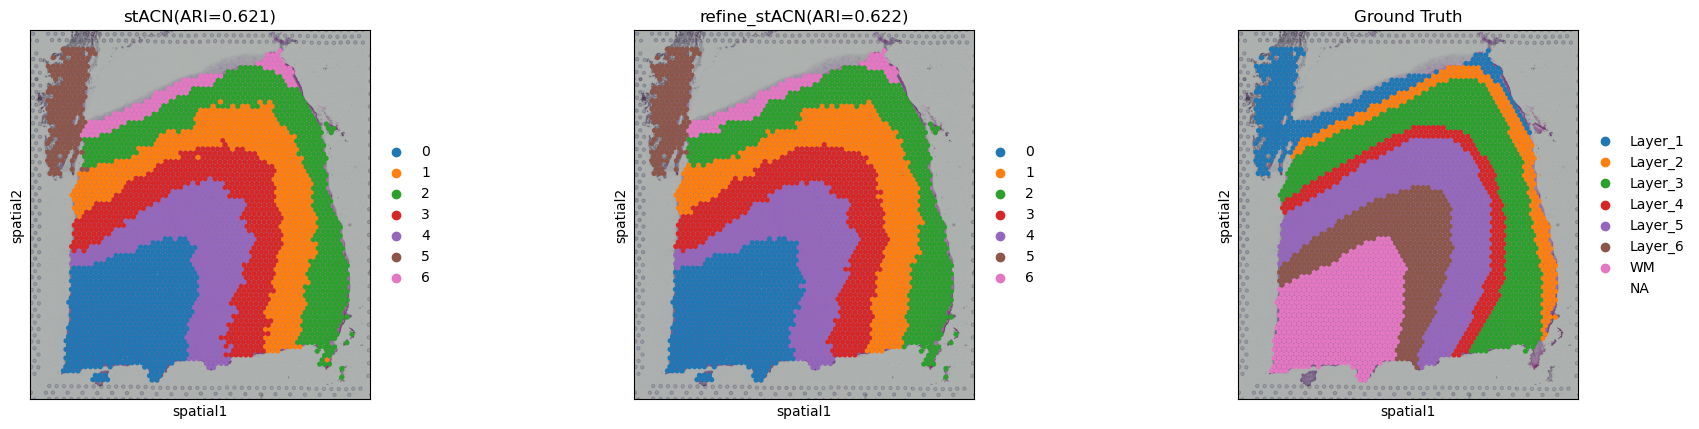

In [10]:
from src.utils import refine
weights_adj = cell_spatial.A
refined_pred = refine(sample_id=adata.obs.index.tolist(), pred=adata.obs['stACN'].tolist(),dis=weights_adj, shape="hexagon")
adata.obs["refined_pred"] = refined_pred
adata.obs["refined_pred"] = adata.obs["refined_pred"].astype('category')
stACN_ari = adjusted_rand_score(pd.Categorical(adata.obs['Ground Truth']).codes, adata.obs['stACN'])
refine_ari = adjusted_rand_score(pd.Categorical(adata.obs['Ground Truth']).codes, adata.obs['refined_pred'])
sc.pl.spatial(adata, color=['stACN', 'refined_pred', 'Ground Truth'], title=['stACN(ARI=%.3f)'% stACN_ari, 'refine_stACN(ARI=%.3f)'%refine_ari, 'Ground Truth'], size=1.5)

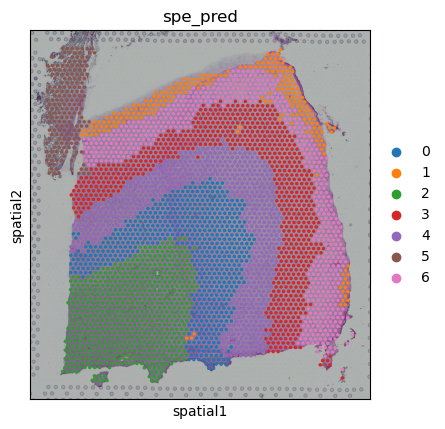

In [11]:
from sklearn.cluster import SpectralClustering
n_clusters = 7
spectral = SpectralClustering(n_clusters=n_clusters)
labels = spectral.fit_predict(Z_all)
adjusted_rand_score(pd.Categorical(adata.obs['Ground Truth']).codes, labels)
adata.obs['spe_pred'] = labels
adata.obs["spe_pred"] = adata.obs["spe_pred"].astype('int')
adata.obs['spe_pred'] = adata.obs['spe_pred'].astype('category')
sc.pl.spatial(adata, color=['spe_pred'])

In [12]:
from src.utils import refine

weights_adj = cell_spatial.A
refined_pred = refine(sample_id=adata.obs.index.tolist(), pred=adata.obs['spe_pred'].tolist(), dis=weights_adj, shape="hexagon")
adata.obs["refined_pred"] = refined_pred
adata.obs["refined_pred"] = adata.obs["refined_pred"].astype('category')
stACN_ari = adjusted_rand_score(pd.Categorical(adata.obs['Ground Truth']).codes, adata.obs['spe_pred'])
refine_ari = adjusted_rand_score(pd.Categorical(adata.obs['Ground Truth']).codes, adata.obs['refined_pred'])
stACN_ari, refine_ari

(0.6320300466328755, 0.6358009084104687)

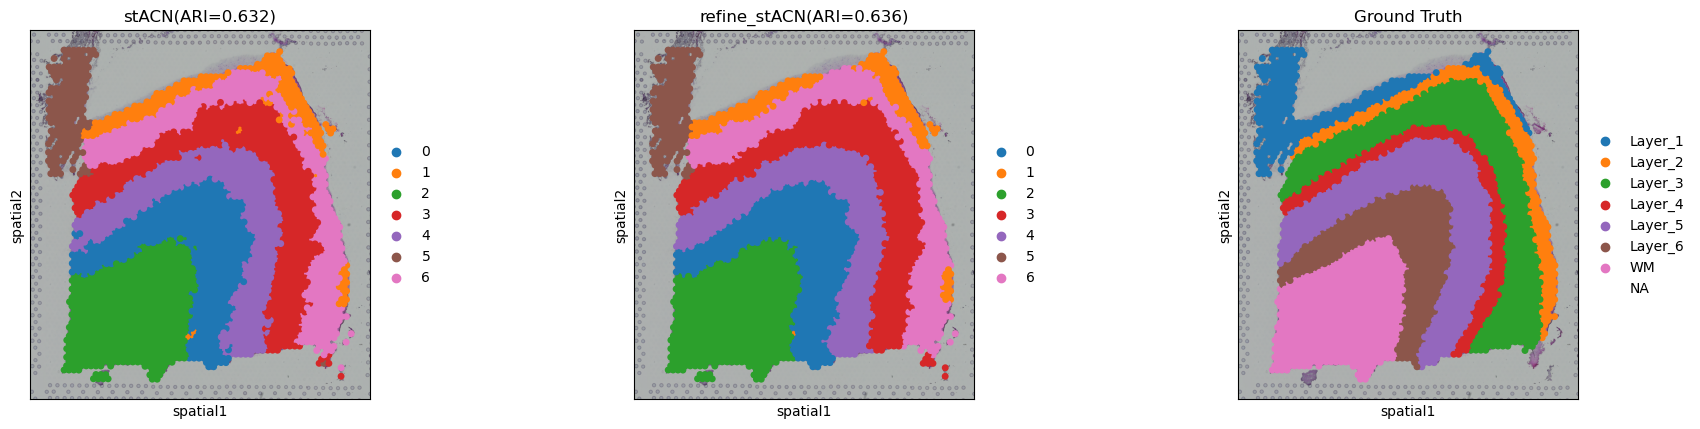

In [13]:
sc.pl.spatial(adata, color=['spe_pred', 'refined_pred', 'Ground Truth'], title=['stACN(ARI=%.3f)'% stACN_ari, 'refine_stACN(ARI=%.3f)'%refine_ari, 'Ground Truth'], size=2)